In [1]:
import hyperspy.api as hs
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import py4DSTEM
from py4DSTEM.io import filereaders
from py4DSTEM.visualize import show
from xml.dom import minidom

In [2]:
data_filepath = '/home/ABTLUS/victor.secco/data_processing/4D-STEM/condicao3/scan_x256_y256.raw'
datacube = filereaders.empad.read_empad(data_filepath, mem='RAM', binfactor=1, metadata=False)

In [17]:
datacube.filter_hot_pixels(
    thresh = 8
)

Cleaning pixels: 100%|██████████| 65536/65536 [00:05<00:00, 12357.38 images/s]


DataCube( A 4-dimensional array of shape (256, 256, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

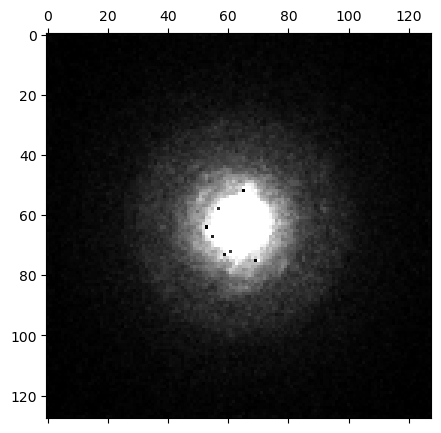

In [3]:
dp = datacube.data[13,30]

show(
    dp,
    #scaling = 'log',
    #intensity_range='absolute',
    #vmin=20,
    #vmax=600000,
    # cmap='viridis',
)

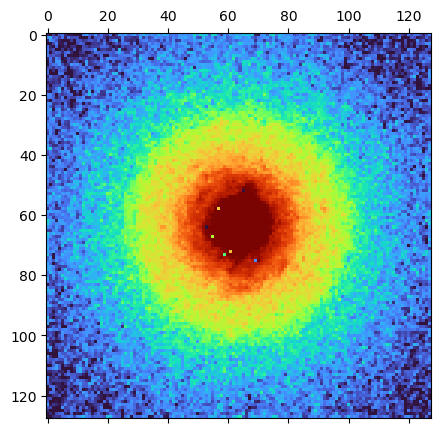

In [7]:
show(
    dp,
    scaling='power',
    power=0.01,
    #vmin=0,
    #vmax=0.95,
    cmap='turbo',
)

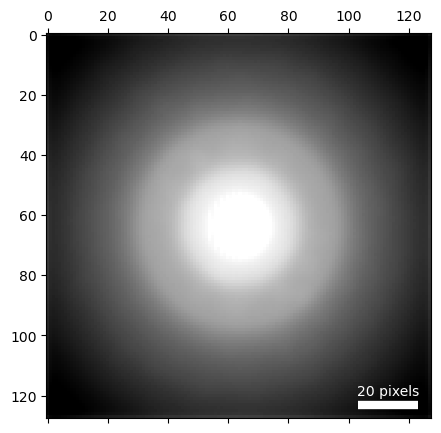

In [4]:
mean_image = datacube.get_dp_mean()

# show
show(
    mean_image,
    scaling='log',
)

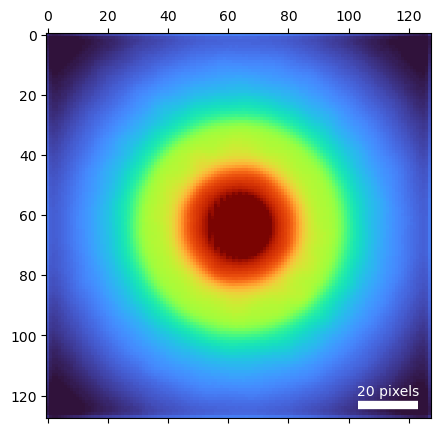

In [5]:
show(
    mean_image,
    scaling='power',
    power=0.25,
    #vmin=0,
    #vmax=0.95,
    cmap='turbo',
)

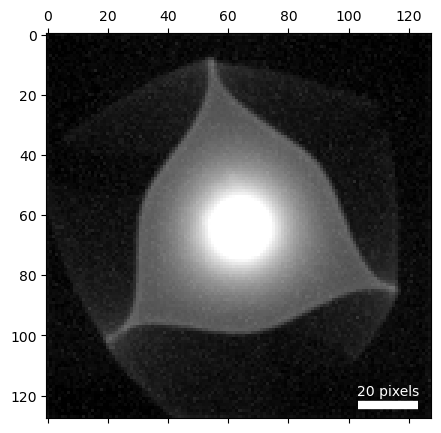

In [6]:
dp_max = datacube.get_dp_max()

# show
show(
    dp_max,
    scaling='power',
    power=0.001,
    #vmin=0,
    #vmax=0.95,
    #cmap='turbo',
)

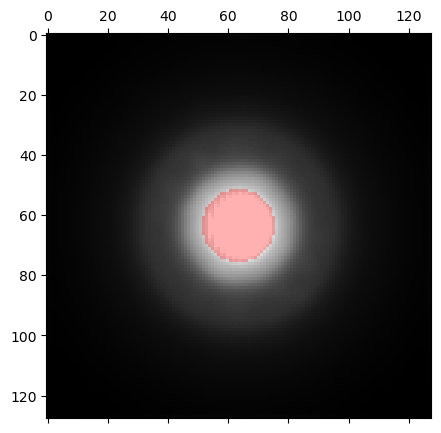

In [7]:
center = (63.5,63.5)
radius = 12


# overlay selected detector position over mean dp
datacube.position_detector(
    data = mean_image,
    mode = 'circle',
    geometry = (
        center,
        radius
    )
)

100%|██████████| 65536/65536 [00:01<00:00, 39870.22it/s]


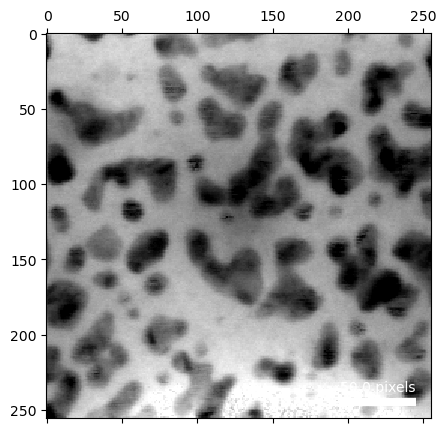

In [8]:
datacube.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',       # the output will be stored in `datacube`'s tree with this name
)

# show
show( datacube.tree('bright_field') )

In [9]:
probe_semiangle, probe_qx0, probe_qy0 = datacube.get_probe_size(
    mean_image.data,
)

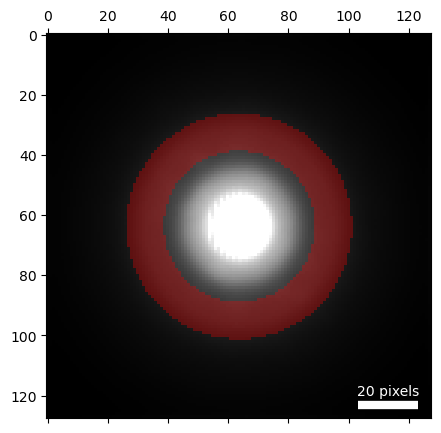

100%|██████████| 65536/65536 [00:01<00:00, 42260.32it/s]


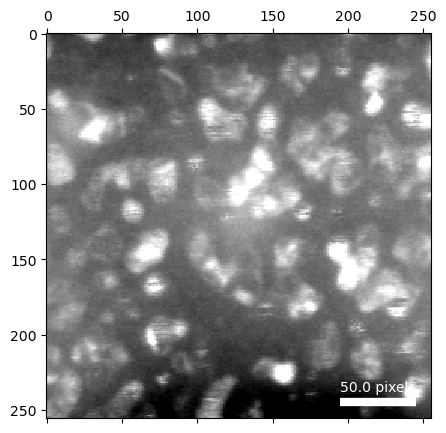

In [10]:
center = probe_qx0, probe_qy0
r_inner = probe_semiangle * 8
r_outer = probe_semiangle * 12
radii = r_inner,r_outer

# overlay selected detector position over mean dp
datacube.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii
    )
)

# compute
datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'annular_dark_field'
)

# show
show(datacube.tree('annular_dark_field'))

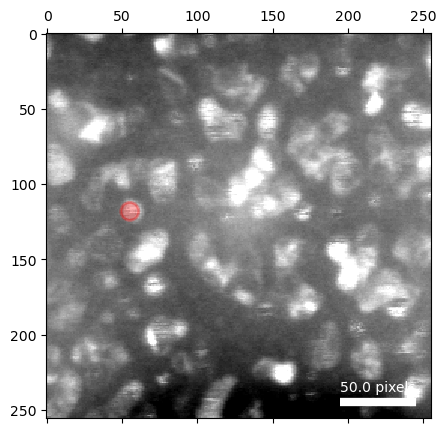

In [14]:
mask_x0, mask_y0 = 118, 55
mask_radius = 6


# plot the mask geometry, overlaid onto the dark field image we created earlier
py4DSTEM.visualize.show(
    datacube.tree('annular_dark_field'),
    circle = {
      'center':(mask_x0, mask_y0),
      'R': mask_radius,
      'alpha':0.3,
      'fill':True
    }
)

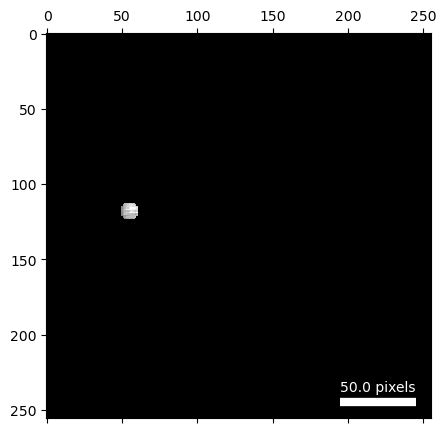

In [15]:
import numpy as np
ryy,rxx = np.meshgrid(
    np.arange(datacube.R_Ny),
    np.arange(datacube.R_Nx),
)
rrr = np.hypot( rxx-mask_x0, ryy-mask_y0 )
mask = rrr < mask_radius

# show
show(
    datacube.tree('annular_dark_field'),
    mask = mask
)

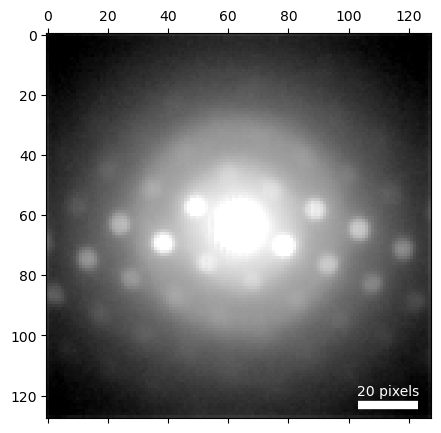

In [16]:
selected_area_diffraction_01 = datacube.get_virtual_diffraction(
    method = 'mean',
    mask = mask,
    name = 'selected_area_diffraction_01'
)

# show
py4DSTEM.visualize.show(
    selected_area_diffraction_01,
    scaling='log',
)

In [20]:
# select a vacuum region
datacube.tree()

/
|---dp_mean
|---bright_field
|---annular_dark_field
|---selected_area_diffraction_01


In [21]:
filepath_save = data_filepath + 'analysis_basics_01.h5'

py4DSTEM.save(
    filepath_save,
    datacube,
    tree = None,  # this indicates saving everything *under* datacube, but not not datacube itself
    mode = 'o'    # this says that if a file of this name already exists, we'll overwrite it
)

In [ ]:
probe = datacube.get_vacuum_probe( ROI=mask )

show(
    probe.probe,
    scaling='none',
    intensity_range='absolute',
    vmin=0,
    vmax=7.2e3
)